In [2]:

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
import cartopy.feature as cfeature
from scipy import stats
from scipy.interpolate import griddata
import plotly.express as px

In [3]:
def crop_da(ds,min_lon,max_lon,min_lat,max_lat):

    mask_lon = (ds.lon >= min_lon) & (ds.lon <= max_lon)
    mask_lat = (ds.lat >= min_lat) & (ds.lat <= max_lat)

    ds = ds.where(mask_lon & mask_lat, drop=True)
    return ds

In [4]:
def rgb_to_grayscale(da):
    """Converts an RGB xarray DataArray to grayscale."""
    return (da.sel(rgb='red') * 0.2989 + 
            da.sel(rgb='green') * 0.5870 + 
            da.sel(rgb='blue') * 0.1140)

In [5]:


def remapping_3d_fields(xr_input,vars, output_lons, output_lats,output_times=None):

    input_lons = xr_input['lon'].values
    input_lats = xr_input['lat'].values
    input_times = xr_input['time'].values

    if output_times is None:
        output_times = input_times

    if len(input_lons.shape)==1:
        input_lons3, input_lats3= np.meshgrid(input_lons, input_lats)
    elif len(input_lons.shape)==2:

        input_lons3, input_lats3= np.meshgrid(input_lons[0,:], input_lats[0,:])
        # input_lons3 = np.repeat(input_lons[:,None,:], input_lats.shape[-1],axis=1)
        # input_lats3 = np.repeat(input_lats[:,:,None], input_lons.shape[-1],axis=2)
        # input_times3 = np.repeat(input_times[:,None], input_lons.shape[1],axis=1)
        # input_times3 = np.repeat(input_times3[:,:,None], input_lons.shape[2],axis=2)
    elif len(input_lons.shape)==3:
        input_lons3 = input_lons[0,...]
        input_lats3 = input_lats[0,...]
        # input_times3 = np.repeat(input_times[:,None], input_lons.shape[1],axis=1)
        # input_times3 = np.repeat(input_times3[:,:,None], input_lons.shape[2],axis=2)
    
    if len(output_lons.shape)==1:
        output_lons3, output_lats3 = np.meshgrid(output_lons, output_lats)
    elif len(output_lons.shape)==2:
        output_lons3, output_lats3= np.meshgrid(output_lons[0,:], output_lats[0,:])
        # output_lons3 = np.repeat(output_lons[:,None,:], output_lats.shape[-1],axis=1)
        # output_lats3 = np.repeat(output_lats[:,:,None], output_lons.shape[-1],axis=2)
        # output_times3 = np.repeat(output_times[:,  None], output_lons.shape[1],axis=1)
        # output_times3 = np.repeat(output_times3[:,:,None], output_lons.shape[2],axis=2)
    elif len(output_lons.shape)==3:
        output_lons3 = output_lons[0,...]
        output_lats3 = output_lats[0,...]
        # output_times3 = np.repeat(output_times[:,  None], output_lons.shape[1],axis=1)
        # output_times3 = np.repeat(output_times3[:,:,None], output_lons.shape[2],axis=2)
    
    input_lons3 = input_lons3.flatten()
    input_lats3 = input_lats3.flatten()
    # input_times3 = input_times3.flatten()
    # output_lons3 = output_lons3.flatten()
    # output_lats3 = output_lats3.flatten()
    # output_times3 = output_times3.flatten()

    input_points  = np.vstack((input_lons3 , input_lats3 )).T
    output_points = (output_lons3, output_lats3)
    xr_output = xr.Dataset({})
    # xr_output = xr.Dataset({'time': output_times, 'latitude': output_lats, 'longitude': output_lons})

    
    for var in vars:
        print(var)
        output_field = np.zeros((len(input_times),output_lons3.shape[0],output_lons3.shape[1]))
        for itime in range(len(input_times)):
            print('Time:', output_times[itime])
            input_field = xr_input[var].isel(time=itime).values
            output_field[itime,...] = griddata(input_points, input_field.flatten(), output_points, method='linear')
        xr_output[var] = xr.DataArray(output_field, dims=['time','latitude', 'longitude'], coords={'time': output_times,'latitude': output_lats, 'longitude': output_lons})
    return xr_output
    

In [31]:
def init_centers(data, k):
    """
    """
    # Initialize centroids
    centers = np.zeros((k, np.shape(data)[1]))
    # Loop on k centers
    for i in range(0, k):
        # Generate p random values between 0 and 1
        dist = np.random.uniform(size=np.shape(data)[1])
        # Use the random values to generate a point within the range of values taken by the data
        centers[i, :] = np.min(data, axis=0) + (np.max(data, axis=0) - np.min(data, axis=0)) * dist
    return centers

To be able to affect each data point to the closest centroid, we need to define the distance between two data points. The most common distance is the **Euclidean distance**:

$d(x,y) = \sqrt{\sum_{i = 1}^p (x_i - y_i)^2}$

where $x$ and $y$ are two data observation points with $p$ variables. 

We then define a function to compute the distance between each data point and each centroid.

In [38]:
def compute_distance(data, centers, k):
    """
    """
    # Initialize distance
    distance = np.zeros((np.shape(data)[0], k))
    # Loop on n data points
    for i in range(0, np.shape(data)[0]):
        # Loop on k centroids
        for j in range(0, k):
            # Compute distance
            distance[i, j] = np.sqrt(np.sum(np.square(data[i, :] - centers[j, :])))
    return distance

We now define a function to affect each data point to the cluster which centroid is the closest to the point. We also define an objective function that will be minimized until we reach convergence.

Our objective is to minimize the sum of the square of the distance between each point and the closest centroid:

$obj = \sum_{j = 1}^k \sum_{i = 1}^{N_j} d(x^{(i)} , x^{(j)}) ^2$

where $x^{(i)}$ is the $i^{th}$ point in the cluster $j$, $x^{(j)}$ is the centroid of the cluster $j$, and $N_j$ is the number of points in the cluster $j$.

In [33]:
def compute_objective(distance, clusters):
    """
    """
    # Initialize objective
    objective = 0.0
    # Loop on n data points
    for i in range(0, np.shape(distance)[0]):
        # Add distance to the closest centroid
        objective = objective + distance[i, int(clusters[i])] ** 2.0
    return objective

In [34]:
def compute_clusters(distance):
    """
    """
    # Initialize clusters
    clusters = np.zeros(np.shape(distance)[0])
    # Loop on n data points
    for i in range(0, np.shape(distance)[0]):
        # Find closest centroid
        best = np.argmin(distance[i, :])
        # Assign data point to corresponding cluster
        clusters[i] = best
    return clusters

After all points are assigned to a cluster, compute the new location of the centroid. It is just the value of the mean of all the points affected to that cluster:

For $1 \leq j \leq k$, $x_p^{(j)} = \frac{1}{N_j} \sum_{i = 1}^{N_j} x_p^{(i)}$

In [35]:
def compute_centers(data, clusters, k):
    """
    """
    # Initialize centroids
    centers = np.zeros((k, np.shape(data)[1]))
    # Loop on clusters
    for i in range(0, k):
        # Select all data points in this cluster
        subdata = data[clusters == i, :]
        # If no data point in this cluster, generate randomly a new centroid
        if (np.shape(subdata)[0] == 0):
            centers[i, :] = init_centers(data, 1)
        else:
            # Compute the mean location of all data points in this cluster
            centers[i, :] = np.mean(subdata, axis=0)
    return centers

We can now code the K-means algorithm by assembling all these functions. We stop the computation when the objective function no longer decreases.

In [36]:
def my_kmeans(data, k):
    """
    """
    # Initialize centroids
    centers = init_centers(data, k)
    # Initialize objective function to square of the maximum distance between two data points times number of data points
    objective_old = np.shape(data)[0] * np.sum(np.square(np.max(data, axis=0) - np.min(data, axis=0)))
    # Initialize clusters
    clusters_old = np.zeros(np.shape(data)[0])
    # Start loop until convergence
    stop_alg = False
    while stop_alg == False:
        # Compute distance between data points and centroids
        distance = compute_distance(data, centers, k)
        # Get new clusters
        clusters_new = compute_clusters(distance)
        # get new value of objective function
        objective_new = compute_objective(distance, clusters_new)
        # If objective function stops decreasing, end loop
        if objective_new >= objective_old:
            return (clusters_old, objective_old, centers)
        else:
            # Update the locations of the centroids
            centers = compute_centers(data, clusters_new, k)
            objective_old = objective_new
            clusters_old = clusters_new

In [6]:
direc_data = '../full_data/ai_ready/'

In [7]:
# Define the region of interest

min_lon = -125
max_lon = -114
min_lat = 32
max_lat = 42

In [8]:
# Load the datasets
ds_ci = xr.open_dataset(f'{direc_data}CloudImageryDataset.nc')
ds_co = xr.open_dataset(f'{direc_data}CloudOpticalDepthDataset.nc')
ds_sw = xr.open_dataset(f'{direc_data}ReflectedSWDataset.nc')
# Convert the RGB images to grayscale
ds_ci['GrayImagery'] = rgb_to_grayscale(ds_ci.CloudImagery)


In [9]:
# Crop the datasets
ds_ci = crop_da(ds_ci,min_lon,max_lon,min_lat,max_lat)
ds_co = crop_da(ds_co,min_lon,max_lon,min_lat,max_lat)
ds_sw = crop_da(ds_sw,min_lon,max_lon,min_lat,max_lat)

In [10]:
# Reverse the latitude dimension to have it in ascending order

ds_ci=ds_ci.isel(latitude=slice(None, None, -1))
ds_co=ds_co.isel(latitude=slice(None, None, -1))
ds_sw=ds_sw.isel(latitude=slice(None, None, -1))

In [11]:
lon_remapped = np.linspace(-125,-114,11*40+1)
lat_remapped = np.linspace(32,42,10*40+1)


In [12]:
ds_co_remapped = remapping_3d_fields(ds_co, ['CloudOpticalDepth'], lon_remapped, lat_remapped,None)
ds_ci_remapped = remapping_3d_fields(ds_ci, ['GrayImagery'], lon_remapped, lat_remapped,None)
ds_sw_remapped = remapping_3d_fields(ds_sw, ['ReflectedSW'], lon_remapped, lat_remapped,None)

CloudOpticalDepth
Time: 91
Time: 92
Time: 93
Time: 94
Time: 95
Time: 96
Time: 97
Time: 98
Time: 99
Time: 100
GrayImagery
Time: 91
Time: 92
Time: 93
Time: 94
Time: 95
Time: 96
Time: 97
Time: 98
Time: 99
Time: 100
ReflectedSW
Time: 91
Time: 92
Time: 93
Time: 94
Time: 95
Time: 96
Time: 97
Time: 98
Time: 99
Time: 100


In [13]:
COD = ds_co_remapped['CloudOpticalDepth'].values 
CID = ds_ci_remapped['GrayImagery'].values
RSW = ds_sw_remapped['ReflectedSW'].values

In [14]:
COD = COD.flatten()
CID = CID.flatten()
RSW = RSW.flatten()

In [15]:
times = ds_co_remapped.time.values


In [16]:

time3, lat_remapped3, lon_remapped3 = np.meshgrid(ds_co_remapped.time.values,lat_remapped,lon_remapped,indexing='ij')

In [17]:
df = pd.DataFrame({'time':time3.flatten(),'lon':lon_remapped3.flatten(),'lat':lat_remapped3.flatten(),'COD': COD, 'CID': CID, 'RSW': RSW})

In [18]:

df.dropna(inplace=True)
df = df.loc[~((df.COD==0))]# & (df.COD>0) & (df.COD<5.1)

In [19]:
data = df[['COD','CID','RSW']].values

In [22]:
# example of the silhouette score for the Old Faithful data
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_score, silhouette_samples, homogeneity_score
ncluster=4

kmeans_model = KMeans(n_clusters=ncluster, random_state=1).fit(data)
labels = kmeans_model.labels_



In [53]:
df.loc[df.time==times[0]]

,time,lon,lat,COD,CID,RSW
2344,91,-121.525,32.125,4.140871,0.493587,194.303659
2345,91,-121.500,32.125,1.691777,0.398089,192.034164
2346,91,-121.475,32.125,2.605019,0.441833,189.764670
2347,91,-121.450,32.125,3.333172,0.475588,187.495175
2348,91,-121.425,32.125,2.474653,0.438950,185.225681
...,...,...,...,...,...,...
174626,91,-114.225,41.875,15.604272,0.677145,485.715509
174627,91,-114.200,41.875,14.297219,0.668251,487.973102
174628,91,-114.175,41.875,11.685778,0.650886,490.230695
174629,91,-114.150,41.875,12.170473,0.654829,492.488287


For n_clusters = 3 The average silhouette_score is : 0.6229705015750854


Text(0.5, 0.98, 'Silhouette analysis for KMeans clustering on sample data with n_clusters = 3')

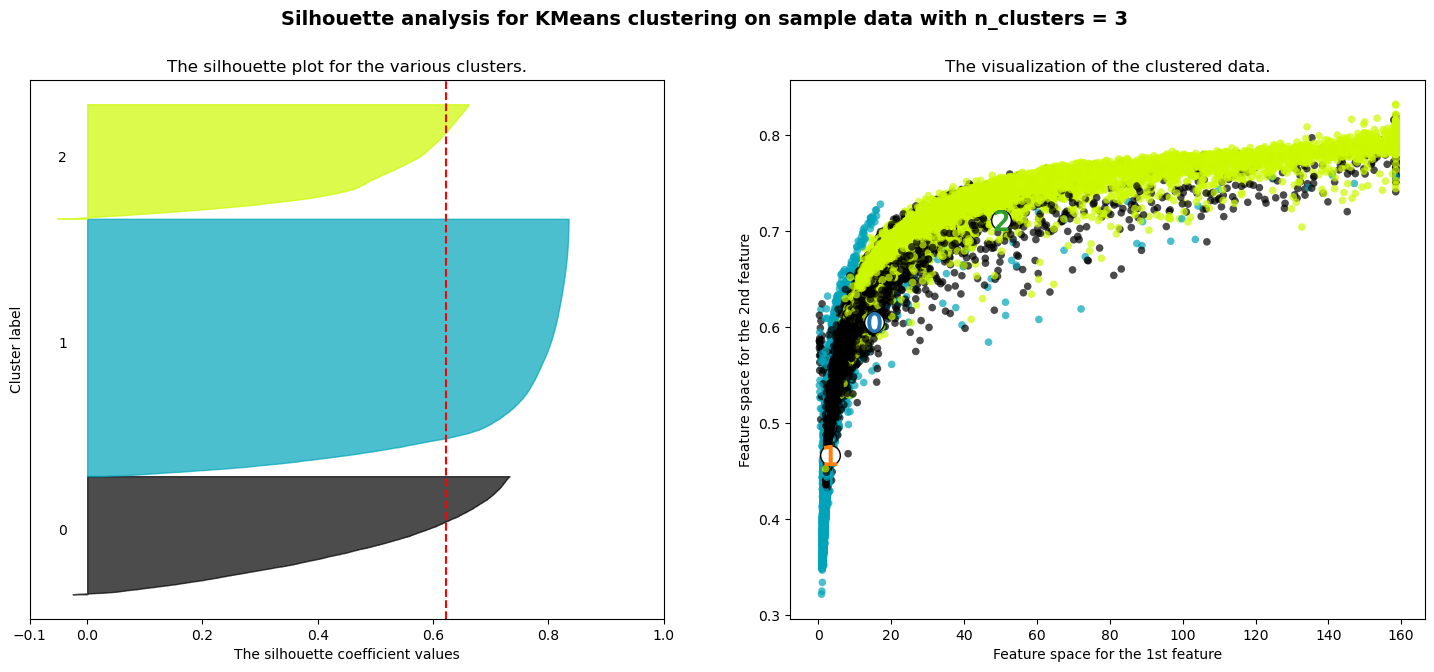

In [54]:
import matplotlib.cm as cm

df0 = df.loc[df.time==times[0]]
data0 = df0[['COD','CID','RSW']].values

ncluster = 3

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
#The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1 but in this example all
# lie within [-0.1, 1]
ax1.set_xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
# ax1.set_ylim([0, len(data) + (ncluster + 1) * 10])
# ax1.set_ylim([0, 10])


# Initialize the clusterer with n_clusters value and a random generator
# seed of 10 for reproducibility.
clusterer = KMeans(n_clusters=ncluster, random_state=10)
cluster_labels = clusterer.fit_predict(data0)
cluster_centers = clusterer.cluster_centers_

# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed
# clusters
silhouette_avg = silhouette_score(data0, cluster_labels)
print(
    "For n_clusters =",
    ncluster,
    "The average silhouette_score is :",
    silhouette_avg,
)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(data0, cluster_labels)

y_lower = 10
for i in range(ncluster):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / ncluster)
    ax1.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
    )

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# 2nd Plot showing the actual clusters formed
colors = cm.nipy_spectral(cluster_labels.astype(float) / ncluster)
ax2.scatter(
    data0[:, 0], data0[:, 1], marker="o", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
)

# Labeling the clusters
centers = clusterer.cluster_centers_
# Draw white circles at cluster centers
ax2.scatter(
    centers[:, 0],
    centers[:, 1],
    marker="o",
    c="white",
    alpha=1,
    s=200,
    edgecolor="k",
)

for i, c in enumerate(centers):
    ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=200, edgecolor=None)

ax2.set_title("The visualization of the clustered data.")
ax2.set_xlabel("Feature space for the 1st feature")
ax2.set_ylabel("Feature space for the 2nd feature")

plt.suptitle(
    "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
    % ncluster,
    fontsize=14,
    fontweight="bold",
)

In [57]:
def compute_elbow(data, clusters, centers, k):
    """
    """
    E = 0
    for i in range(0, k):
        distance = compute_distance(data[clusters == i, :], centers[i, :].reshape(1, -1), 1)
        E = E + np.mean(np.square(distance))
    return E

Compute the value of E for different values of the number of clusters

1
2
3
4
5
6
7
8


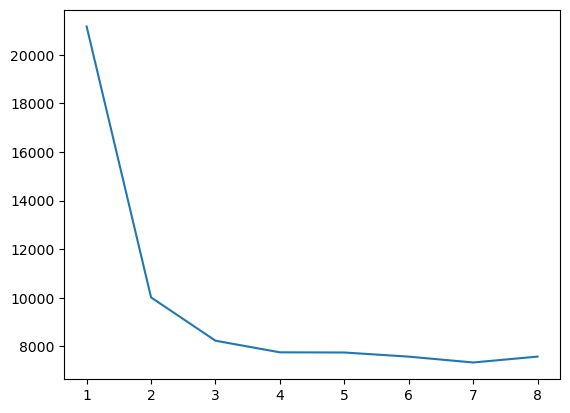

In [58]:
E = np.zeros(8)
for k in range(1, 9):
    print(k)
    clusterer = KMeans(n_clusters=k, random_state=10)
    cluster_labels = clusterer.fit_predict(data0)
    cluster_centers = clusterer.cluster_centers_
    E[k - 1] = compute_elbow(data0, cluster_labels, cluster_centers, k)
plt.plot(np.arange(1, 9), E)

In [59]:
def repeat_kmeans(data, k, N):
    """
    """
    # Initialization
    objective = np.zeros(N)
    clusters = np.zeros((N, np.shape(data)[0]))
    centers = np.zeros((N, k, np.shape(data)[1]))
    # Run K-means N times
    for i in range(0, N):
        result = my_kmeans(data, k)
        clusters[i, :] = result[0]
        objective[i] = result[1]
        centers[i, :, :] = result[2]
        print(i/N*100)
    # Choose the clustering with the best value of the objective function
    best = np.argmin(objective)
    return (clusters[best, :], objective[best], centers[best, :, :])

Repeat k-means 50 times

In [60]:
N = 30
k = 4
print(k,N)
(clusters, objective, centers) = repeat_kmeans(data0, k, N)


4 30
0.0
3.3333333333333335
6.666666666666667
10.0
13.333333333333334
16.666666666666664
20.0
23.333333333333332
26.666666666666668
30.0
33.33333333333333
36.666666666666664
40.0
43.333333333333336
46.666666666666664
50.0
53.333333333333336
56.666666666666664
60.0
63.33333333333333
66.66666666666666
70.0
73.33333333333333
76.66666666666667
80.0
83.33333333333334
86.66666666666667
90.0
93.33333333333333
96.66666666666667


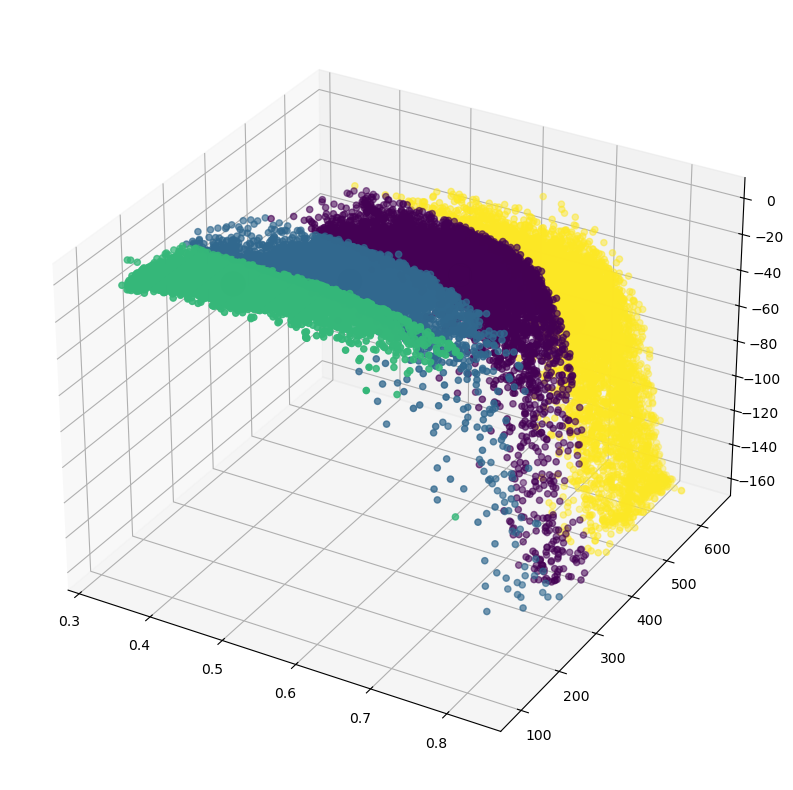

In [63]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data0[:, 1], data0[:, 2], -data0[:, 0], c=clusters)
ax.scatter(centers[:, 1], centers[:, 2], -centers[:, 0], marker='o', s=300, c='black')

Plot $E$ as a function of $k$ and see where reaches a minimum.

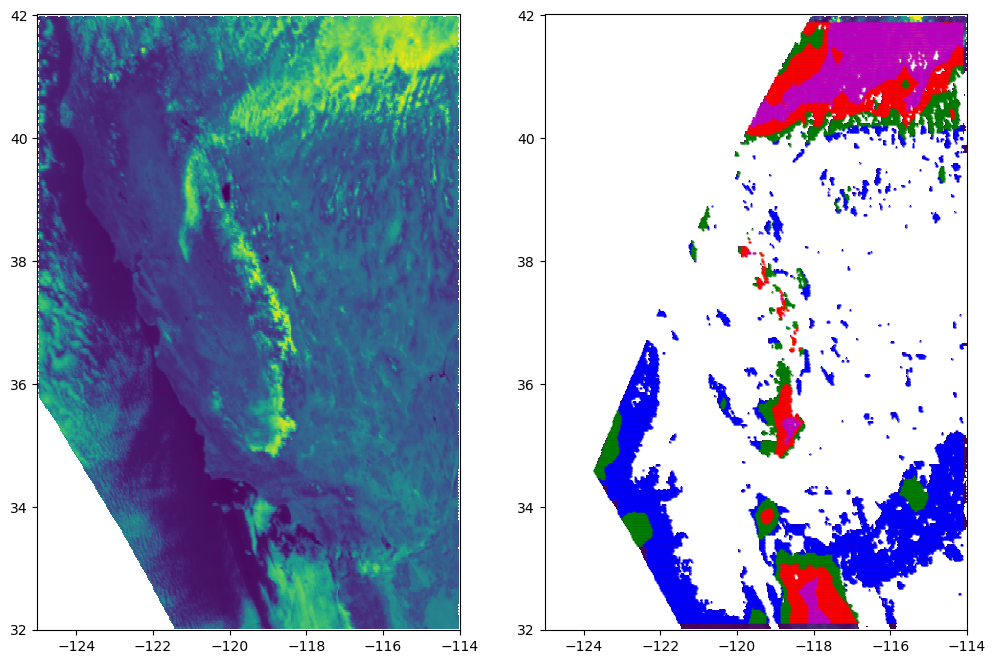

In [72]:
iit =0 
times0 = times[iit]


df_c0 = df0.loc[(df0.time==times0) & (clusters==0)]#.plot.scatter(x='lon',y='lat',c='COD',cmap='viridis') 
df_c1 = df0.loc[(df0.time==times0) & (clusters==1)]#.plot.scatter(x='lon',y='lat',c='COD',cmap='viridis') 
df_c2 = df0.loc[(df0.time==times0) & (clusters==2)]#.plot.scatter(x='lon',y='lat',c='COD',cmap='viridis') 
df_c3 = df0.loc[(df0.time==times0) & (clusters==3)]#.plot.scatter(x='lon',y='lat',c='COD',cmap='viridis') 
fig,axs = plt.subplots(1,2,figsize=(12,8))

axs[0].pcolormesh(ds_co_remapped.longitude,ds_co_remapped.latitude,ds_ci_remapped['GrayImagery'][iit,:,:])
# axs[0].pcolormesh(ds_co_remapped.longitude,ds_co_remapped.latitude,ds_co_remapped['CloudOpticalDepth'][iit,:,:])
axs[1].pcolormesh(ds_co_remapped.longitude,ds_co_remapped.latitude,ds_co_remapped['CloudOpticalDepth'][iit,:,:])
axs[1].scatter(df_c0.lon,df_c0.lat,c='r',s=1,alpha=0.5)
axs[1].scatter(df_c1.lon,df_c1.lat,c='g',s=1,alpha=0.5)
axs[1].scatter(df_c2.lon,df_c2.lat,c='b',s=1,alpha=0.5)
axs[1].scatter(df_c3.lon,df_c3.lat,c='m',s=1,alpha=0.5)
ds_ci.close()
ds_co.close()
ds_sw.close()